In [1]:
import arcpy
import os
import pandas as pd
import numpy as np
from arcpy import env
from arcpy.management import *
from arcpy.conversion import *
from arcpy.da import *
from arcpy.sa import *

In [2]:
# 分析函数
# 取消并行处理
def disable_parallel_processing(func):
    def wrapper(*args, **kwargs):
        with arcpy.EnvManager(parallelProcessingFactor="0"):
            return func(*args, **kwargs)
    return wrapper
# 采样
def sample_point(point_,raster_,out_name):
    """根据栅格采样点,输出为表格"""
    Sample(raster_,point_,out_name,"NEAREST", "OBJECTID", "CURRENT_SLICE", None, '', None, None, "ROW_WISE", "TABLE")
    return None

# 导出CSV
def export_csv(table_,out_path,out_name):
    TableToTable(table_,out_path,out_name)
    return None
# 掩膜提取
def mask_raster(array,mask_ele,cell_size):
    """按掩膜提取栅格,空间参考设定为:CGCS2000_3_Degree_GK_CM_108E"""
    out_raster = arcpy.NumPyArrayToRaster(
    array,
    arcpy.Point(arcpy.env.extent.XMin, arcpy.env.extent.YMin),
    cell_size,
    cell_size,
)
    """按掩膜提取栅格,空间参考设定为:CGCS2000_3_Degree_GK_CM_108E"""
    output_coordinate_system = arcpy.Describe(mask_ele).spatialReference
    with arcpy.EnvManager(outputCoordinateSystem=output_coordinate_system,snapRaster=mask_ele, cellSize=mask_ele):
        result_raster = arcpy.sa.ExtractByMask(out_raster, mask_ele, "INSIDE")
        return result_raster
# 数组整形
def resize_arrays(A, B, fill_value=0):
    """调整数组形状一致,A为参考数组, B为待调整数组, fill_value为填充值"""
    # new_shape = (max(A.shape[0], B.shape[0]), max(A.shape[1], B.shape[1]))
    new_shape = (A.shape[0], A.shape[1])

    if A.shape != new_shape:
        if A.shape[0] < new_shape[0]:
            padding_rows = new_shape[0] - A.shape[0]
            padding = np.full((padding_rows, A.shape[1]), fill_value)
            A = np.vstack((A, padding))
        elif A.shape[0] > new_shape[0]:
            A = A[:new_shape[0], :]

        if A.shape[1] < new_shape[1]:
            pad_width = ((0, 0), (0, new_shape[1] - A.shape[1]))
            A = np.pad(A, pad_width, mode='constant', constant_values=fill_value)
        elif A.shape[1] > new_shape[1]:
            A = A[:, :new_shape[1]]
    
    if B.shape != new_shape:
        if B.shape[0] < new_shape[0]:
            padding_rows = new_shape[0] - B.shape[0]
            padding = np.full((padding_rows, B.shape[1]), fill_value)
            B = np.vstack((B, padding))
        elif B.shape[0] > new_shape[0]:
            B = B[:new_shape[0], :]

        if B.shape[1] < new_shape[1]:
            pad_width = ((0, 0), (0, new_shape[1] - B.shape[1]))
            B = np.pad(B, pad_width, mode='constant', constant_values=fill_value)
        elif B.shape[1] > new_shape[1]:
            B = B[:, :new_shape[1]]
    
    return A, B
# rf寻找最优参数
def rf_best_param(X_train,y_train,n_estimators_range,k=5):
    """默认为5折交叉验证,评价指标为R2"""
    # 设置树的数目范围
    n_estimators_range = n_estimators_range
    cv_scores = []
    # 使用交叉验证
    for n_estimators in n_estimators_range:
        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
        scores = cross_val_score(rf,X_train, y_train, cv=k, scoring='accuracy')  # K折交叉验证 分类问题默认使用accuracy
        cv_scores.append(scores.mean())
    # 选择最优数量的树
    optimal_n_estimators = n_estimators_range[cv_scores.index(max(cv_scores))]
    return optimal_n_estimators

# arcpy栅格众数滤波
@disable_parallel_processing
def mode_filter(in_raster,filter_size="FOUR",filter_method="MAJORITY"):
    """栅格众数滤波,filter_size:滤波窗口大小,filter_method:滤波方法"""
    result_raster = MajorityFilter(in_raster, filter_size, filter_method) # 默认为4邻域 众数滤波  可选为8邻域 半数滤波
    return result_raster
    
# arcpy栅格边界清理
@disable_parallel_processing
def clean_boundary(in_raster,sort_method="NO_SORT",clean_method="TWO_WAY"):
    """栅格边界清理,sort_method:排序方法,clean_method:清理方法"""
    result_raster = BoundaryClean(in_raster, "NO_SORT", "TWO_WAY") # 默认为不排序 两边清理 可选为排序 一边清理
    return result_raster
# arcpy栅格区域分组
@disable_parallel_processing
def region_group(in_raster,group_size="FOUR",method="WITHIN",add_link="ADD_LINK",clear=None):
    """栅格区域分组,group_size:分组大小,method:分组方法,add_link:添加链接,clear:排除的值"""
    result_raster = RegionGroup(in_raster, group_size, method, add_link, clear) # 默认为4邻域 分组方法为WITHIN 可选为8邻域 分组方法为CROSS
    return result_raster
# arcpy栅格按属性提取
@disable_parallel_processing
def extract_by_attributes(in_raster,where_clause="count >= 100"):
    """栅格按属性提取,where_clause:属性条件"""
    result_raster = ExtractByAttributes(in_raster, where_clause) # 默认为count >= 200
    return result_raster

# arcpy栅格Nibble
@disable_parallel_processing
def nibble(in_raster,mask_raster, nibble_mask="ALL_VALUES", nibble_values="PRESERVE_NODATA"):
    """栅格Nibble,nibble_mask:掩膜,nibble_values:填充值"""
    result_raster = Nibble(in_raster, mask_raster,nibble_mask, nibble_values) # 默认为ALL_VALUES PRESERVE_NODATA 可选为DATA_ONLY PRESERVE_DATA
    return result_raster

# arcpy栅格查找表
@disable_parallel_processing
def lookup(in_raster,lookup_field="LINK"):
    """栅格查找表,lookup_field:查找字段"""
    result_raster = Lookup(in_raster, lookup_field) # 默认为LINK
    return result_raster


In [3]:
raster_path = r"D:\ArcGISProjects\workspace\shbyq\feature_soiltype_result\feature_soiltype_result_dy.gdb\prediction_soiltype_RFE_20240429_simple"
result_path = r"D:\ArcGISProjects\workspace\shbyq\feature_soiltype_result\feature_soiltype_result_dy.gdb\prediction_soiltype_RFE_20240429_simple_smooth"

In [4]:
# --->>>概化栅格
# 读取栅格 并整型
indoor_raster = Raster(raster_path)
int_raster = Int(indoor_raster)
# 1.众数滤波
# raster_majority_filter = mode_filter(int_raster,"FOUR","MAJORITY")
raster_majority_filter = mode_filter(int_raster,"EIGHT","MAJORITY")

# 2.边界清理
raster_boundary_clean = clean_boundary(raster_majority_filter,"NO_SORT","TWO_WAY")

# 3.区域分组
raster_region_group = region_group(raster_boundary_clean,"FOUR","WITHIN","ADD_LINK",None)
# raster_region_group = region_group(raster_boundary_clean,"EIGHT","WITHIN","ADD_LINK",None)

# 4.提取区域边界
raster_region_boundary = extract_by_attributes(raster_region_group,"COUNT > 50")

# 5.查找表
raster_lookup = lookup(raster_region_group,"LINK")

# 5.蚕食
raster_nibble = nibble(raster_lookup,raster_region_boundary,"ALL_VALUES","PRESERVE_NODATA")
# 6.区域并保存
Int(raster_nibble).save(result_path)

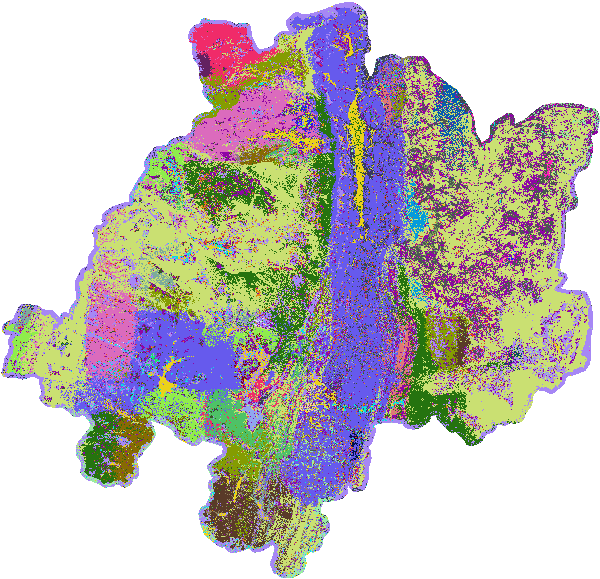

In [5]:
arcpy.sa.Int(raster_path)

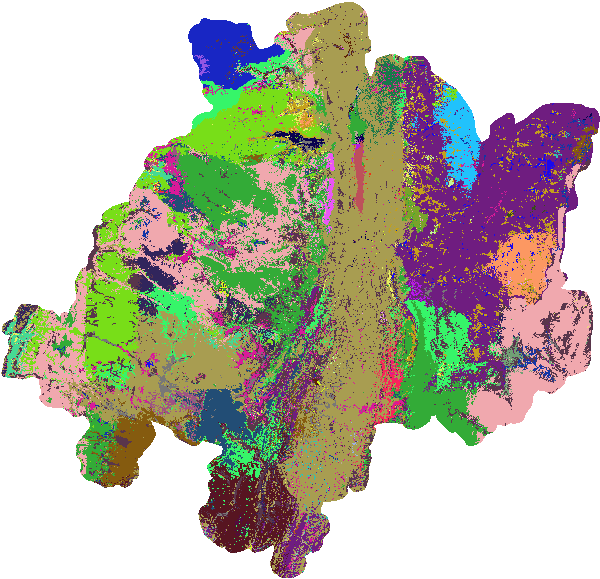

In [6]:
arcpy.sa.Int(result_path)